# Deep Knowledge Tracing
Authors: Lisa Wang, Angela Sy

### Task: Predict what the student is going to code next.

Input: For each of the N students, we have a time series of Abstract Syntax Trees (ASTs), which represent the student's code at that time step.
- input shape (num_students, num_timesteps, num_asts)
    - num_timesteps is the max sequence length of asts that we are taking into account.
    - num_asts is the total number of asts for that problem.

Output: At each timestep, we are predicting the next AST.
- Output shape (num_students, num_timesteps, num_asts). (one-hot encoding)

The truth matrix contains the desired output for a given input, and is used to compute the loss as well as train/val/test accuracies.
- Truth shape (num_students, num_timesteps) Values are in range (0, num_asts)

Accuracy:
- Raw Accuracy: For all predictions at all timesteps, we get the percentage of predictions we got correct.
- Corrected Accuracy: Since many trajectories contain fewer asts than max_traj_len, we fill the empty asts with our dummy ast token at row 0. However, predicting on end tokens is to simple of a task and might bias our results. The corrected accuracy ignores all predictions on the end token.

### Current Issues:
AST IDs are not consistent across different HOCs. Hence, we can only train and run this model on each HOC individually.


In [1]:
# Python libraries
import numpy as np
import theano
import theano.tensor as Tensor
import lasagne
import random
import sys
import csv
import time
import matplotlib.pyplot as plt
import pickle
# allows plots to show inline in ipython notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Import our own modules
import utils
import model_predict_ast as model
import visualize
from constants import *

In [13]:
# hyperparameters
hidden_size = 256 # size of hidden layer of neurons
learning_rate = 1e-2
lr_decay = 0.995
reg_strength = 2e-2
grad_clip = 10
batchsize = 32
num_epochs = 4
dropout_p = 0.5
num_lstm_layers = 1
theano.config.optimizer='fast_compile'
theano.config.exception_verbosity='high'

In [6]:
def full_train_test_run(hoc_num):
    X, y, ast_maps, num_asts = utils.load_dataset_predict_ast(hoc_num, use_embeddings=False)
    num_traj, num_timesteps, embed_dim = X.shape
    # make train, val, test split
    train_data, val_data, test_data = utils.get_train_val_test_split((X,y))
    # create model
    train_loss_acc, compute_loss_acc, probs, l_out = model.create_model(num_timesteps, num_asts, \
               hidden_size, learning_rate, embed_dim=-1, grad_clip=grad_clip, dropout_p=dropout_p, num_lstm_layers=num_lstm_layers)
    # Training!
    train_losses, train_accs, train_corrected_accs, val_losses, val_accs, val_corrected_accs = \
        model.train(train_data, val_data, train_loss_acc, compute_loss_acc, num_epochs=num_epochs, batchsize=batchsize, record_per_iter=True)
    # Evaluate on test set
    test_loss, test_raw_acc, test_corrected_acc, test_corrected_acc_per_timestep, pred_test = \
        model.check_accuracy(test_data, compute_loss_acc, dataset_name='test', compute_acc_per_timestep_bool=True)
 
    num_train = train_data[0].shape[0]
    visualize.plot_loss_acc('hoc'+ str(hoc_num) + '_train', train_losses, train_corrected_accs, val_corrected_accs, \
                            learning_rate, reg_strength, num_epochs, num_train, xlabel='iterations')  
    np.savez('../saved_models/predict_ast_with_astid_model_' + str(hoc_num) + '.npz', lasagne.layers.get_all_param_values(l_out))
    return train_corrected_accs[-1], val_corrected_accs[-1], test_corrected_acc, test_corrected_acc_per_timestep

Training and testing predict_next_ast rnn on Hour of Code problem #1
Preparing network inputs and targets, and the ast maps...
Inputs and targets done!
Building network ...
Computing updates ...
Compiling functions ...
Compiling done!
Starting training...
Total training iterations: 144
Ep 0 	iter 1  	loss 5.27348, train acc 0.00, train corr acc 0.00, val acc 68.07, val corr acc 29.65
Ep 0 	iter 2  	loss 5.12689, train acc 67.19, train corr acc 25.88, val acc 73.29, val corr acc 41.15
Ep 0 	iter 3  	loss 4.58716, train acc 70.31, train corr acc 35.23, val acc 71.49, val corr acc 37.17
Ep 0 	iter 4  	loss 2.96079, train acc 73.44, train corr acc 39.29, val acc 71.29, val corr acc 36.73
Ep 0 	iter 5  	loss 1.72613, train acc 72.40, train corr acc 37.65, val acc 71.29, val corr acc 36.73
Ep 0 	iter 6  	loss 1.30930, train acc 73.96, train corr acc 39.02, val acc 71.29, val corr acc 36.73
Ep 0 	iter 7  	loss 2.01915, train acc 64.58, train corr acc 32.00, val acc 71.29, val corr acc 36.73
E

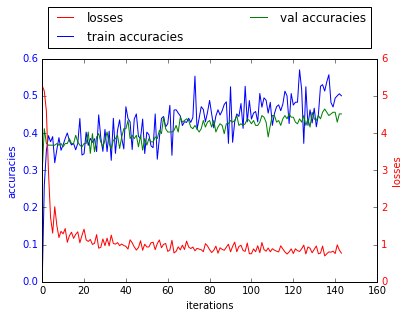

In [14]:
last_train_corrected_acc = {}
last_val_corrected_acc = {}
test_corrected_acc = {}
test_corrected_acc_per_timestep = {}

hoc_num = 1
print ('Training and testing predict_next_ast rnn on Hour of Code problem #{}'.format(hoc_num))
last_train_corrected_acc[hoc_num], last_val_corrected_acc[hoc_num], test_corrected_acc[hoc_num], test_corrected_acc_per_timestep[hoc_num] = full_train_test_run(hoc_num) 
print ('='*100)

# for hoc_num in xrange(HOC_MIN, HOC_MAX+1):
#     print ('Training and testing predict_next_ast rnn on Hour of Code problem #{}'.format(hoc_num))
#     last_train_corrected_acc[hoc_num], last_val_corrected_acc[hoc_num], test_corrected_acc[hoc_num], test_corrected_acc_per_timestep[hoc_num] = full_train_test_run(hoc_num) 
#     print ('='*100)

In [7]:
for hoc_num in xrange(HOC_MIN, HOC_MAX+1):
    print ('Accuracies for HOC {}:'.format(hoc_num))
    print ('last train acc: {:.2f} %'.format(last_train_corrected_acc[hoc_num] * 100))
    print ('last val acc: {:.2f} %'.format(last_val_corrected_acc[hoc_num] * 100))
    print ('overall test acc: {:.2f} %'.format(test_corrected_acc[hoc_num] * 100))
    print ('test accs time series: {}'.format(test_corrected_acc_per_timestep[hoc_num]))

Accuracies for HOC 1:
last train acc: 53.57 %
last val acc: 46.02 %
overall test acc: 47.01 %
test accs time series: [0.24096385542168675, 0.3815789473684211, 0.7547169811320755, 0.9473684210526315, 1.0, -1.0]
Accuracies for HOC 2:
last train acc: 56.73 %
last val acc: 52.61 %
overall test acc: 53.59 %
test accs time series: [0.1597222222222222, 0.5481481481481482, 0.8736842105263158, 1.0, 1.0, -1.0, -1.0]
Accuracies for HOC 3:
last train acc: 53.33 %
last val acc: 52.58 %
overall test acc: 52.56 %
test accs time series: [0.21223021582733814, 0.3258426966292135, 0.6919831223628692, 0.8875, 0.9871794871794872, 1.0]
Accuracies for HOC 4:
last train acc: 54.10 %
last val acc: 55.37 %
overall test acc: 53.43 %
test accs time series: [0.18333333333333332, 0.4067796610169492, 0.6677018633540373, 0.8551401869158879, 0.9797979797979798, 1.0, 1.0, 1.0]
Accuracies for HOC 5:
last train acc: 62.18 %
last val acc: 55.31 %
overall test acc: 56.51 %
test accs time series: [0.17647058823529413, 0.485